In [1]:
import numpy as np
import math
import random

# ---------------------------
# Global Seed
# ---------------------------
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

# ---------------------------
# Problem Parameters
# ---------------------------
NUM_ROOMS = 10       # Number of hotel rooms
TIME_SLOTS = 24      # Number of time intervals in a day (e.g., 24 hours)
MIN_TEMP = 20.0      # Minimum allowed temperature (°C)
MAX_TEMP = 25.0      # Maximum allowed temperature (°C)
comfort_temp = 22.5  # Desired temperature when a room is occupied

# ---------------------------
# Environment Simulation Functions
# ---------------------------
def generate_outside_temperatures():
    """
    Simulate outside temperatures over the day using a sinusoidal pattern
    with added randomness. Peak temperature occurs around midday.
    
    Returns:
        np.array: Array of length TIME_SLOTS.
    """
    temps = np.empty(TIME_SLOTS)
    for t in range(TIME_SLOTS):
        # Sinusoidal pattern: average 20°C with amplitude 10°C, peak near noon
        temp = 20 + 10 * math.sin(2 * math.pi * (t - 6) / 24)
        # Add random fluctuation
        temp += random.uniform(-2, 2)
        temps[t] = temp
    return temps

def generate_door_open_schedule(prob_open=0.2):
    """
    Generate a schedule indicating whether a room's door is open at each time slot.
    
    Returns:
        np.array: Boolean array of shape (NUM_ROOMS, TIME_SLOTS).
    """
    return (np.random.rand(NUM_ROOMS, TIME_SLOTS) < prob_open)

def generate_orientation_factors():
    """
    Assign an orientation factor to each room based on its facing direction.
    For example, south-facing rooms might have a factor of 1.1 (more sun exposure),
    while north-facing rooms might have a factor of 0.9.
    
    Returns:
        np.array: Array of shape (NUM_ROOMS,) containing the factors.
    """
    orientations = ['north', 'south', 'east', 'west']
    factors = {'north': 0.9, 'south': 1.1, 'east': 1.0, 'west': 1.0}
    room_factors = np.array([factors[random.choice(orientations)] for _ in range(NUM_ROOMS)])
    return room_factors

def generate_occupancy_schedule(occupancy_prob=0.6):
    """
    Simulate an occupancy schedule where each room is occupied at a given time slot 
    with probability `occupancy_prob`.
    
    Returns:
        np.array: Boolean array of shape (NUM_ROOMS, TIME_SLOTS).
    """
    return (np.random.rand(NUM_ROOMS, TIME_SLOTS) < occupancy_prob)

def generate_price_schedule(month):
    """
    Generate a price schedule (EUR per energy unit) for each time slot based on the month.
    
    A simple simulation is used where:
      - Base price is 0.2 EUR/kWh.
      - Hourly variation is modeled with a sine pattern.
      - A month-based multiplier adjusts the cost (e.g., winter months cost more).
    
    Parameters:
        month (int): Month number (1-12).
        
    Returns:
        np.array: Array of length TIME_SLOTS with the price per energy unit.
    """
    base_price = 0.2  # Base EUR per kWh
    # Month factors: assume higher energy cost in winter, lower in summer.
    month_factors = {1: 1.2, 2: 1.2, 3: 1.1, 4: 1.0, 5: 0.9, 6: 0.9,
                     7: 0.8, 8: 0.8, 9: 0.9, 10: 1.0, 11: 1.1, 12: 1.2}
    m_factor = month_factors.get(month, 1.0)
    hours = np.arange(TIME_SLOTS)
    hourly_variation = 0.1 * np.sin(2 * math.pi * hours / TIME_SLOTS)
    price = (base_price + hourly_variation) * m_factor
    return price

# ---------------------------
# Global Precomputed Environment Data
# ---------------------------
outside_temps = generate_outside_temperatures()         # Shape: (TIME_SLOTS,)
door_open_schedule = generate_door_open_schedule(prob_open=0.2)  # Shape: (NUM_ROOMS, TIME_SLOTS), boolean
orientation_factors = generate_orientation_factors()     # Shape: (NUM_ROOMS,)
occupancy_schedule = generate_occupancy_schedule(occupancy_prob=0.6)  # Shape: (NUM_ROOMS, TIME_SLOTS), boolean
current_month = 1  # Example: January
price_schedule = generate_price_schedule(current_month)  # Shape: (TIME_SLOTS,)

# ---------------------------
# Chromosome & Random Solution Generation
# ---------------------------
def generate_random_solution():
    """
    Generates a random solution (chromosome) as a 1D NumPy array.
    
    Each gene is a temperature setpoint for a given room and time slot,
    uniformly sampled from [MIN_TEMP, MAX_TEMP].
    
    Returns:
        np.array: 1D array of length NUM_ROOMS * TIME_SLOTS.
    """
    return np.random.uniform(MIN_TEMP, MAX_TEMP, size=NUM_ROOMS * TIME_SLOTS)

# ---------------------------
# Fitness Function
# ---------------------------
def fitness(chromosome):
    """
    Calculate the fitness of a chromosome, expressed as the total money spent on energy (EUR).
    
    The fitness includes:
      1. **Energy Cost Calculation:**  
         - For each room and time slot, the energy consumption is determined by the difference
           between the setpoint and the outside temperature.
         - Heating is applied if the setpoint is above the outside temperature; cooling if below.
         - A base energy consumption is added.
         - Energy consumption is then adjusted using room orientation factors and door-opening events.
         - Finally, each hour's energy consumption is multiplied by a simulated hourly energy price.
         
      2. **Penalties:**  
         - **Temperature Range Violations:** A penalty of 1000 EUR per degree is added if any setpoint 
           falls outside the allowed range \([MIN\_TEMP, MAX\_TEMP]\).
         - **Occupancy Comfort:** When a room is occupied, a penalty of 50 EUR per degree deviation from the 
           desired comfort temperature is applied.
           
    The function is fully vectorized for efficiency.
    
    Parameters:
        chromosome (np.array): 1D array of length NUM_ROOMS * TIME_SLOTS.
        
    Returns:
        float: Total cost in EUR (lower is better).
    """
    # Reshape chromosome into 2D array (rooms x time slots)
    setpoints = chromosome.reshape((NUM_ROOMS, TIME_SLOTS))
    
    # --- Penalties ---
    # Temperature range violation penalty
    lower_violation = np.maximum(0, MIN_TEMP - setpoints)
    upper_violation = np.maximum(0, setpoints - MAX_TEMP)
    penalty_range = 1000 * (np.sum(lower_violation) + np.sum(upper_violation))
    
    # Occupancy comfort penalty (only apply where room is occupied)
    comfort_penalty = 50 * np.sum(np.abs(setpoints - comfort_temp) * occupancy_schedule)
    
    # --- Energy Consumption Calculation ---
    # Compute the difference between setpoint and outside temperature (broadcasting the outside_temps array)
    delta = setpoints - outside_temps  # Shape: (NUM_ROOMS, TIME_SLOTS)
    
    # Calculate energy consumption:
    #   - For heating (delta > 0): energy = delta * 1.5
    #   - For cooling (delta <= 0): energy = (-delta) * 1.2
    energy_consumption = np.where(delta > 0, delta * 1.5, -delta * 1.2)
    # Add a fixed base consumption per room per time slot
    energy_consumption += 0.5
    
    # Adjust consumption for room orientation (broadcast orientation factors)
    energy_consumption *= orientation_factors[:, np.newaxis]
    
    # Adjust for door opening events: multiply by 1.1 if door is open
    door_factor = np.where(door_open_schedule, 1.1, 1.0)
    energy_consumption *= door_factor
    
    # --- Cost Calculation ---
    # Multiply the energy consumption by the hourly price for each time slot (price_schedule broadcasts)
    cost_matrix = energy_consumption * price_schedule
    total_energy_cost = np.sum(cost_matrix)
    
    # Total fitness = energy cost + penalties
    total_cost = total_energy_cost + penalty_range + comfort_penalty
    return total_cost

# ---------------------------
# Example Usage
# ---------------------------
if __name__ == "__main__":
    # Generate a random solution (chromosome) as a 1D array.
    solution = generate_random_solution()
    
    # Evaluate its fitness (total energy cost in EUR)
    cost = fitness(solution)
    print("Fitness (Total Energy Cost in EUR) of a random solution:", cost)
    # Use the same initial solution for consistency
    init_solution = generate_random_solution()


Fitness (Total Energy Cost in EUR) of a random solution: 9256.071614675717


In [2]:
import random
import numpy as np

def genetic_algorithm(
        population_size=100,
        num_generations=100,
        selection_method='tournament',   # Options: 'tournament', 'roulette', 'rank', 'sus', 'truncation'
        selection_params=None,
        crossover_method='one_point',      # Options: 'one_point', 'two_point', 'uniform'
        crossover_params=None,
        mutation_method='gaussian',        # Options: 'gaussian', 'bit_flip'
        mutation_params=None,
        replacement_method='generational', # Options: 'generational', 'steady_state', 'elitist', 'generational_mixing'
        replacement_params=None,
        elitism_rate=0.05,
        verbose=False):
    """
    Genetic Algorithm (GA) Function.

    -----------------------
    This function implements a Genetic Algorithm for optimization. It begins with a randomly 
    generated population and evolves it over a number of generations. In each generation, the following steps occur:

      1. Selection:
         - Parents are chosen from the current population based on their fitness.
         - Possible Options (with example parameters):
             * 'tournament': Individuals compete in small groups, and the best one is selected. 
               e.g., selection_params = {'tournament_size': 3}
             * 'roulette': Selection probability is proportional to fitness (higher fitness means higher chance of selection).
               e.g., selection_params = {}
             * 'rank': Individuals are ranked by fitness, and selection probability is based on rank.
               e.g., selection_params = {}
             * 'sus': Stochastic Universal Sampling, ensuring a more even selection distribution.
               e.g., selection_params = {}
             * 'truncation': Only the top fraction of the population is selected for reproduction.
               e.g., selection_params = {'truncation_rate': 0.5}
      
      2. Crossover (Recombination):
         - Selected parents are recombined to produce offspring.
         - Possible Options:
             * 'one_point': A single crossover point is selected, and genes are swapped beyond that point.
             * 'two_point': Two crossover points are selected, and genes between them are swapped.
             * 'uniform': Each gene is inherited randomly from one of the two parents.
      
      3. Mutation:
         - Offspring undergo random modifications to maintain diversity.
         - Possible Options:
             * 'gaussian': Adds random noise from a Gaussian distribution to real-valued genes.
               e.g., mutation_params = {'mutation_rate': 0.1, 'sigma': 0.1}
             * 'bit_flip': Flips bits in a binary representation with a certain probability.
               e.g., mutation_params = {'mutation_rate': 0.01}
      
      4. Replacement (Survivor Selection):
         - The next generation is formed by replacing individuals in the population.
         - Possible Options:
             * 'generational': The entire population is replaced by the offspring, except for elite individuals.
               e.g., replacement_method = 'generational', elitism_rate = 0.05
             * 'steady_state': Only a few individuals are replaced at each step, maintaining population stability.
               e.g., replacement_method = 'steady_state'
             * 'generational_mixing': Offspring and parents are mixed, and the best individuals survive.
               e.g., replacement_method = 'generational_mixing'

    Parameters:
        population_size (int): Number of individuals in the population.
        num_generations (int): Number of generations to evolve.
        selection_method (str): Method for selecting parents.
        selection_params (dict): Parameters for the selection method.
        crossover_method (str): Method for recombining parents.
        crossover_params (dict): Parameters for the crossover operator.
        mutation_method (str): Method for mutating offspring.
        mutation_params (dict): Parameters for the mutation operator.
        replacement_method (str): Strategy for forming the next generation.
        replacement_params (dict): Parameters for the replacement method.
        elitism_rate (float): Fraction of the best individuals to retain (for elitist replacement).
        verbose (bool): If True, display progress using tqdm.

    Returns:
        tuple: A tuple containing:
            - best_solution (list): The best solution found (converted to a list).
            - best_fitness (float): The fitness value of the best solution.

    """
    # Set default parameters if none are provided.
    if selection_params is None:
        if selection_method == 'tournament':
            selection_params = {'tournament_size': 3}
        elif selection_method == 'truncation':
            selection_params = {'truncation_rate': 0.5}
        else:
            selection_params = {}
    if crossover_params is None:
        crossover_params = {}
    if mutation_params is None:
        if mutation_method == 'gaussian':
            mutation_params = {'mutation_rate': 0.1, 'sigma': 0.1}
        elif mutation_method == 'bit_flip':
            mutation_params = {'mutation_rate': 0.01}
        else:
            mutation_params = {}
    if replacement_params is None:
        replacement_params = {}

    # ---------------------------
    # Helper functions: Selection Operators
    # ---------------------------
    def tournament_selection(population, fitnesses, params):
        tournament_size = params.get('tournament_size', 3)
        selected = random.sample(list(zip(population, fitnesses)), tournament_size)
        selected.sort(key=lambda x: x[1])
        return selected[0][0]
    
    def roulette_selection(population, fitnesses, params):
        epsilon = 1e-6
        fitness_inv = [1.0 / (f + epsilon) for f in fitnesses]
        total = sum(fitness_inv)
        probabilities = [f / total for f in fitness_inv]
        index = np.random.choice(len(population), p=probabilities)
        return population[index]
    
    def rank_selection(population, fitnesses, params):
        sorted_indices = np.argsort(fitnesses)
        N = len(population)
        # p(i) = (2*(N - i))/(N*(N+1)) where i = 0 (best) to N-1 (worst)
        probs = np.array([2*(N - i) for i in range(1, N+1)]) / (N*(N+1))
        chosen_index = np.random.choice(N, p=probs)
        return population[sorted_indices[chosen_index]]
    
    def sus_selection(population, fitnesses, params):
        epsilon = 1e-6
        fitness_inv = [1.0 / (f + epsilon) for f in fitnesses]
        total = sum(fitness_inv)
        # For one selection, the pointer distance is total.
        start_point = np.random.uniform(0, total)
        cumulative_sum = 0.0
        for ind, fit_inv in zip(population, fitness_inv):
            cumulative_sum += fit_inv
            if cumulative_sum >= start_point:
                return ind
        return population[-1]
    
    def truncation_selection(population, fitnesses, params):
        truncation_rate = params.get('truncation_rate', 0.5)
        N = len(population)
        num_to_select = max(1, int(N * truncation_rate))
        sorted_indices = np.argsort(fitnesses)
        chosen_index = np.random.randint(0, num_to_select)
        return population[sorted_indices[chosen_index]]
    
    if selection_method == 'tournament':
        selection_operator = tournament_selection
    elif selection_method == 'roulette':
        selection_operator = roulette_selection
    elif selection_method == 'rank':
        selection_operator = rank_selection
    elif selection_method == 'sus':
        selection_operator = sus_selection
    elif selection_method == 'truncation':
        selection_operator = truncation_selection
    else:
        raise ValueError("Unknown selection method: {}".format(selection_method))
    
    # ---------------------------
    # Helper functions: Crossover Operators
    # ---------------------------
    def one_point_crossover(parent1, parent2, params):
        point = np.random.randint(1, len(parent1))
        child1 = np.concatenate([parent1[:point], parent2[point:]])
        child2 = np.concatenate([parent2[:point], parent1[point:]])
        return [child1, child2]
    
    def two_point_crossover(parent1, parent2, params):
        point1 = np.random.randint(1, len(parent1) - 1)
        point2 = np.random.randint(point1 + 1, len(parent1))
        child1 = np.concatenate([parent1[:point1], parent2[point1:point2], parent1[point2:]])
        child2 = np.concatenate([parent2[:point1], parent1[point1:point2], parent2[point2:]])
        return [child1, child2]
    
    def uniform_crossover(parent1, parent2, params):
        mask = np.random.rand(len(parent1)) < 0.5
        child1 = np.where(mask, parent1, parent2)
        child2 = np.where(mask, parent2, parent1)
        return [child1, child2]
    
    if crossover_method == 'one_point':
        crossover_operator = one_point_crossover
    elif crossover_method == 'two_point':
        crossover_operator = two_point_crossover
    elif crossover_method == 'uniform':
        crossover_operator = uniform_crossover
    else:
        raise ValueError("Unknown crossover method: {}".format(crossover_method))
    
    # ---------------------------
    # Helper functions: Mutation Operators
    # ---------------------------
    def gaussian_mutation(individual, params):
        mutation_rate = params.get('mutation_rate', 0.1)
        sigma = params.get('sigma', 0.1)
        mutated = individual.copy()
        for i in range(len(mutated)):
            if np.random.rand() < mutation_rate:
                mutated[i] += np.random.normal(0, sigma)
        mutated = np.clip(mutated, MIN_TEMP, MAX_TEMP)
        return mutated
    
    def bit_flip_mutation(individual, params):
        mutation_rate = params.get('mutation_rate', 0.01)
        mutated = individual.copy()
        for i in range(len(mutated)):
            if np.random.rand() < mutation_rate:
                mutated[i] = 1 - mutated[i]
        return mutated
    
    if mutation_method == 'gaussian':
        mutation_operator = gaussian_mutation
    elif mutation_method == 'bit_flip':
        mutation_operator = bit_flip_mutation
    else:
        raise ValueError("Unknown mutation method: {}".format(mutation_method))
    
    # ---------------------------
    # Helper functions: Replacement Operators
    # ---------------------------
    def generational_replacement(population, offspring, fitnesses):
        elite_count = int(elitism_rate * population_size)
        if elite_count > 0:
            sorted_indices = np.argsort(fitnesses)
            elites = [population[i] for i in sorted_indices[:elite_count]]
            return elites + offspring[elite_count:]
        return offspring
    
    def steady_state_replacement(population, offspring, fitnesses):
        combined = population + offspring
        combined_fitness = [fitness(ind) for ind in combined]
        sorted_indices = np.argsort(combined_fitness)
        return [combined[i] for i in sorted_indices[:population_size]]
    
    def generational_mixing_replacement(population, offspring, fitnesses):
        combined = population + offspring
        combined_fitness = [fitness(ind) for ind in combined]
        sorted_indices = np.argsort(combined_fitness)
        return [combined[i] for i in sorted_indices[:population_size]]
    
    if replacement_method in ['generational', 'elitist']:
        replacement_operator = generational_replacement
    elif replacement_method == 'steady_state':
        replacement_operator = steady_state_replacement
    elif replacement_method == 'generational_mixing':
        replacement_operator = generational_mixing_replacement
    else:
        raise ValueError("Unknown replacement method: {}".format(replacement_method))
    
    # ---------------------------
    # Main Genetic Algorithm Loop
    # ---------------------------
    population = [generate_random_solution() for _ in range(population_size)]
    best_solution = None
    best_fitness = float('inf')
    
    if verbose:
        from tqdm import tqdm
        generation_iter = tqdm(range(num_generations), desc="GA Generations")
    else:
        generation_iter = range(num_generations)
    
    for gen in generation_iter:
        fitnesses = [fitness(ind) for ind in population]
        current_best = min(fitnesses)
        if current_best < best_fitness:
            best_fitness = current_best
            best_solution = population[fitnesses.index(current_best)]
        
        offspring = []
        while len(offspring) < population_size:
            parent1 = selection_operator(population, fitnesses, selection_params)
            parent2 = selection_operator(population, fitnesses, selection_params)
            children = crossover_operator(parent1, parent2, crossover_params)
            mutated_children = [mutation_operator(child, mutation_params) for child in children]
            offspring.extend(mutated_children)
        
        offspring = offspring[:population_size]
        population = replacement_operator(population, offspring, fitnesses)
    
    return best_solution.tolist(), best_fitness

# -----------------------------------------------------------------------------
# Possible Options for GA Operators and Example Parameters (as comments):
#
# Selection Methods:
#   - 'tournament':   e.g., selection_method = 'tournament', selection_params = {'tournament_size': 3}
#   - 'roulette':     e.g., selection_method = 'roulette', selection_params = {}
#   - 'rank':         e.g., selection_method = 'rank', selection_params = {}
#   - 'sus':          e.g., selection_method = 'sus', selection_params = {}
#   - 'truncation':   e.g., selection_method = 'truncation', selection_params = {'truncation_rate': 0.5}
#
# Crossover Methods:
#   - 'one_point':    e.g., crossover_method = 'one_point'
#   - 'two_point':    e.g., crossover_method = 'two_point'
#   - 'uniform':      e.g., crossover_method = 'uniform'
#
# Mutation Methods:
#   - 'gaussian':     e.g., mutation_method = 'gaussian', mutation_params = {'mutation_rate': 0.1, 'sigma': 0.1}
#   - 'bit_flip':     e.g., mutation_method = 'bit_flip', mutation_params = {'mutation_rate': 0.01}
#
# Replacement Methods:
#   - 'generational':       e.g., replacement_method = 'generational', elitism_rate = 0.05
#   - 'steady_state':       e.g., replacement_method = 'steady_state'
#   - 'generational_mixing':e.g., replacement_method = 'generational_mixing'
#
# -----------------------------------------------------------------------------


best_sol, best_fit = genetic_algorithm(
    population_size=40,
    num_generations=500,
    selection_method='tournament',
    selection_params={'tournament_size': 3},
    crossover_method='uniform',
    mutation_method='gaussian',
    mutation_params={'mutation_rate': 0.1, 'sigma': 0.1},
    replacement_method='generational',
    elitism_rate=0.05,
    verbose=True
)
print("\nGenetic Algorithm Best Fitness:", best_fit)


GA Generations: 100%|██████████| 500/500 [00:01<00:00, 292.34it/s]


Genetic Algorithm Best Fitness: 878.0212916245966


Varying Population Size: 100%|██████████| 7/7 [00:19<00:00,  2.81s/it]


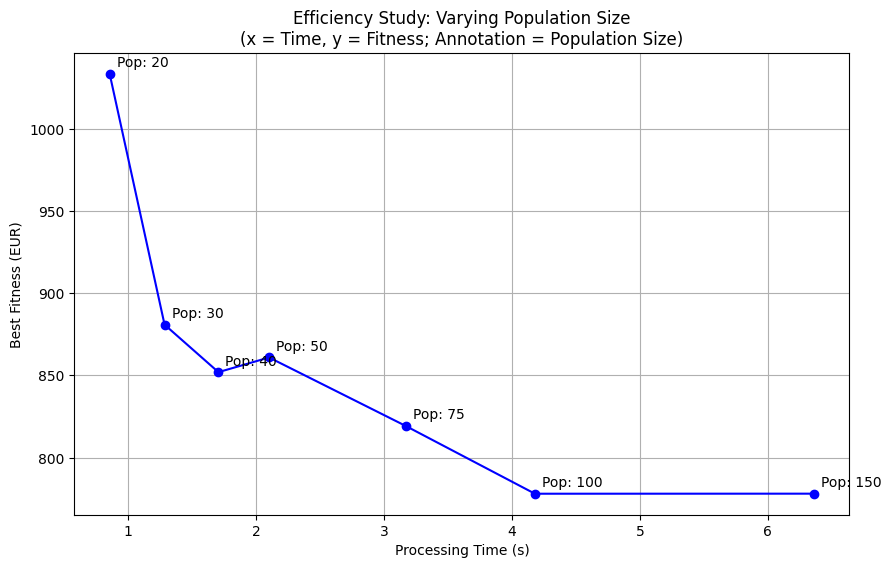

Varying Number of Generations: 100%|██████████| 6/6 [00:55<00:00,  9.21s/it]


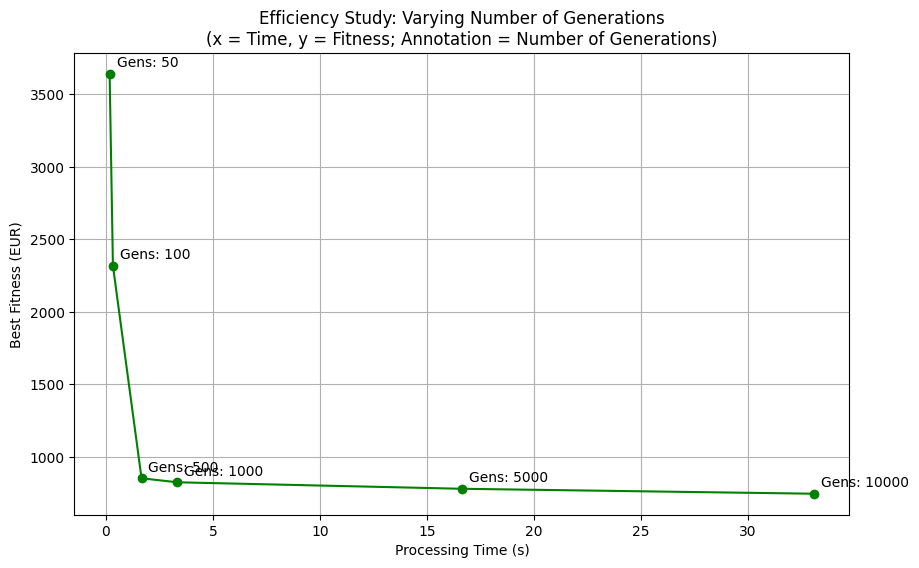

In [17]:
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
import random

# Fixed GA operator parameters:
sel_method = 'tournament'
sel_params = {'tournament_size': 3}
cross_method = 'uniform'
mut_method = 'gaussian'
mut_params = {'mutation_rate': 0.1, 'sigma': 0.1}
rep_method = 'generational'
elitism_rate = 0.05
GLOBAL_SEED = 42  # Global seed for reproducibility

# --- Efficiency Study 1: Varying Population Size ---
population_sizes = [20, 30, 40, 50, 75, 100, 150]
fixed_num_generations = 500  # Fixed number of generations for this study

fitness_vs_pop = []
times_vs_pop = []

for pop in tqdm(population_sizes, desc="Varying Population Size"):
    # Reset the seed before each run
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)
    
    start = time.time()
    best_sol, best_fit = genetic_algorithm(
        population_size=pop,
        num_generations=fixed_num_generations,
        selection_method=sel_method,
        selection_params=sel_params,
        crossover_method=cross_method,
        mutation_method=mut_method,
        mutation_params=mut_params,
        replacement_method=rep_method,
        elitism_rate=elitism_rate,
        verbose=False
    )
    elapsed = time.time() - start
    fitness_vs_pop.append(best_fit)
    times_vs_pop.append(elapsed)

# Plot: x = processing time (s), y = best fitness, annotate with population size
plt.figure(figsize=(10, 6))
plt.plot(times_vs_pop, fitness_vs_pop, marker='o', linestyle='-', color='b')
for i, pop in enumerate(population_sizes):
    plt.annotate(f"Pop: {pop}", (times_vs_pop[i], fitness_vs_pop[i]),
                 textcoords="offset points", xytext=(5,5))
plt.xlabel("Processing Time (s)")
plt.ylabel("Best Fitness (EUR)")
plt.title("Efficiency Study: Varying Population Size\n(x = Time, y = Fitness; Annotation = Population Size)")
plt.grid(True)
plt.show()


# --- Efficiency Study 2: Varying Number of Generations ---
num_generations_list = [50, 100, 500, 1000, 5000, 10000]
fixed_population_size = 40  # Fixed population size for this study

fitness_vs_gen = []
times_vs_gen = []

for gens in tqdm(num_generations_list, desc="Varying Number of Generations"):
    # Reset the seed before each run
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)
    
    start = time.time()
    best_sol, best_fit = genetic_algorithm(
        population_size=fixed_population_size,
        num_generations=gens,
        selection_method=sel_method,
        selection_params=sel_params,
        crossover_method=cross_method,
        mutation_method=mut_method,
        mutation_params=mut_params,
        replacement_method=rep_method,
        elitism_rate=elitism_rate,
        verbose=False
    )
    elapsed = time.time() - start
    fitness_vs_gen.append(best_fit)
    times_vs_gen.append(elapsed)

# Plot: x = processing time (s), y = best fitness, annotate with number of generations
plt.figure(figsize=(10, 6))
plt.plot(times_vs_gen, fitness_vs_gen, marker='o', linestyle='-', color='g')
for i, gens in enumerate(num_generations_list):
    plt.annotate(f"Gens: {gens}", (times_vs_gen[i], fitness_vs_gen[i]),
                 textcoords="offset points", xytext=(5,5))
plt.xlabel("Processing Time (s)")
plt.ylabel("Best Fitness (EUR)")
plt.title("Efficiency Study: Varying Number of Generations\n(x = Time, y = Fitness; Annotation = Number of Generations)")
plt.grid(True)
plt.show()


Varying Number of Generations: 100%|██████████| 6/6 [00:21<00:00,  3.66s/it]


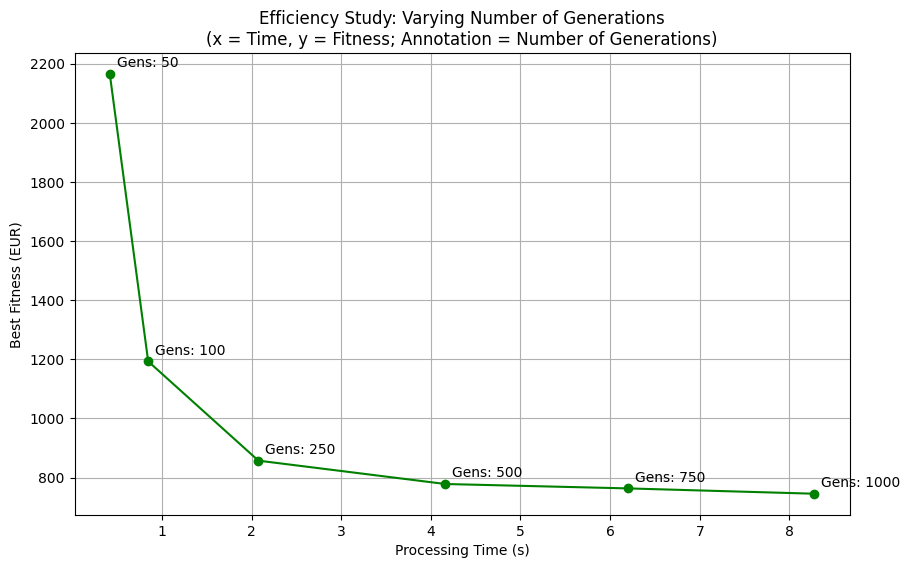

In [19]:
# --- Efficiency Study 2: Varying Number of Generations ---
num_generations_list = [50, 100,250, 500,750, 1000]
fixed_population_size = 100  # Fixed population size for this study

fitness_vs_gen = []
times_vs_gen = []

for gens in tqdm(num_generations_list, desc="Varying Number of Generations"):
    # Reset the seed before each run
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)
    
    start = time.time()
    best_sol, best_fit = genetic_algorithm(
        population_size=fixed_population_size,
        num_generations=gens,
        selection_method=sel_method,
        selection_params=sel_params,
        crossover_method=cross_method,
        mutation_method=mut_method,
        mutation_params=mut_params,
        replacement_method=rep_method,
        elitism_rate=elitism_rate,
        verbose=False
    )
    elapsed = time.time() - start
    fitness_vs_gen.append(best_fit)
    times_vs_gen.append(elapsed)

# Plot: x = processing time (s), y = best fitness, annotate with number of generations
plt.figure(figsize=(10, 6))
plt.plot(times_vs_gen, fitness_vs_gen, marker='o', linestyle='-', color='g')
for i, gens in enumerate(num_generations_list):
    plt.annotate(f"Gens: {gens}", (times_vs_gen[i], fitness_vs_gen[i]),
                 textcoords="offset points", xytext=(5,5))
plt.xlabel("Processing Time (s)")
plt.ylabel("Best Fitness (EUR)")
plt.title("Efficiency Study: Varying Number of Generations\n(x = Time, y = Fitness; Annotation = Number of Generations)")
plt.grid(True)
plt.show()

In [ ]:
import random
import numpy as np
import time
from tqdm import tqdm
import concurrent.futures

# Assuming GLOBAL_SEED is defined globally:
GLOBAL_SEED = 42

# Define a helper function to run one GA combination.
def run_ga_combination(combo_index, combo, pop_size, num_gens):
    """
    Runs a single GA combination.
    
    Parameters:
        combo_index (int): The index of this combination.
        combo (tuple): A tuple of operator choices and parameter settings.
        pop_size (int): Population size.
        num_gens (int): Number of generations.
    
    Returns:
        dict: A dictionary containing the combination index, operator settings,
              best fitness, and elapsed time.
    """
    # Unpack combination parameters
    sel_method, sel_params, cross_method, mut_method, mut_params, rep_method, rep_params = combo
    
    # Reset the random seed before each run
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)
    
    start_time = time.time()
    best_sol, best_fit = genetic_algorithm(
        population_size=pop_size,
        num_generations=num_gens,
        selection_method=sel_method,
        selection_params=sel_params,
        crossover_method=cross_method,
        mutation_method=mut_method,
        mutation_params=mut_params,
        replacement_method=rep_method,
        replacement_params=rep_params,
        elitism_rate=rep_params.get('elitism_rate', 0.0),
        verbose=False
    )
    elapsed = time.time() - start_time
    return {
        'combination': combo_index,
        'sel_method': sel_method,
        'sel_params': sel_params,
        'cross_method': cross_method,
        'mut_method': mut_method,
        'mut_params': mut_params,
        'rep_method': rep_method,
        'rep_params': rep_params,
        'best_fitness': best_fit,
        'time': elapsed
    }

def ga_parameter_study_parallel():
    """
    Perform a comprehensive parameter study for the Genetic Algorithm using 16 processes.
    
    The study explores a grid of operator choices and parameter settings for:
      - Selection: methods and parameters (tournament_size or truncation_rate variations)
      - Crossover: methods ('one_point', 'two_point', 'uniform')
      - Mutation: methods and parameters (gaussian: mutation_rate and sigma; bit_flip: mutation_rate)
      - Replacement: methods and parameters (for generational/elitist/generational_mixing: elitism_rate variations;
                                           steady_state with no extra parameters)
    
    Each combination is run using fixed GA settings (population_size and num_generations) and the best fitness and
    time are recorded.
    
    Returns:
        list of dicts: A list where each dict contains the parameter combination and the corresponding results.
    """
    results = []
    combination_index = 0
    # Fixed GA settings for the study
    pop_size = 100
    num_gens = 500
    
    # Define grids for each operator:
    selection_methods = ['tournament', 'roulette', 'rank', 'sus', 'truncation']
    selection_params_grid = {}
    for method in selection_methods:
        if method == 'tournament':
            selection_params_grid[method] = [{'tournament_size': ts} for ts in [2, 3, 5]]
        elif method == 'truncation':
            selection_params_grid[method] = [{'truncation_rate': tr} for tr in [0.3, 0.5, 0.7]]
        else:
            selection_params_grid[method] = [{}]
    
    crossover_methods = ['one_point', 'two_point', 'uniform']
    
    mutation_methods = ['gaussian', 'bit_flip']
    mutation_params_grid = {}
    for method in mutation_methods:
        if method == 'gaussian':
            mutation_params_grid[method] = [{'mutation_rate': mr, 'sigma': s} 
                                            for mr in [0.05, 0.1, 0.2] for s in [0.05, 0.1, 0.2]]
        elif method == 'bit_flip':
            mutation_params_grid[method] = [{'mutation_rate': br} for br in [0.005, 0.01, 0.02]]
    
    replacement_methods = ['generational', 'steady_state', 'elitist', 'generational_mixing']
    replacement_params_grid = {}
    for method in replacement_methods:
        if method in ['generational', 'elitist', 'generational_mixing']:
            replacement_params_grid[method] = [{'elitism_rate': er} for er in [0.03, 0.05, 0.1]]
        else:
            replacement_params_grid[method] = [{}]
    
    # Build a list of all combinations
    combinations = []
    for sel_method in selection_methods:
        for sel_params in selection_params_grid[sel_method]:
            for cross_method in crossover_methods:
                for mut_method in mutation_methods:
                    for mut_params in mutation_params_grid[mut_method]:
                        for rep_method in replacement_methods:
                            for rep_params in replacement_params_grid[rep_method]:
                                combinations.append((sel_method, sel_params, cross_method, mut_method, mut_params, rep_method, rep_params))
    
    total_combinations = len(combinations)
    print(f"Total parameter combinations to test: {total_combinations}")
    
    # Use ProcessPoolExecutor with 16 workers for parallel processing.
    with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
        # Prepare futures for each combination
        futures = []
        for idx, combo in enumerate(combinations, start=1):
            futures.append(executor.submit(run_ga_combination, idx, combo, pop_size, num_gens))
        
        # Use tqdm to show progress as futures complete
        for future in tqdm(concurrent.futures.as_completed(futures), total=total_combinations, desc="GA Parameter Study"):
            result = future.result()
            results.append(result)
    
    best_result = min(results, key=lambda r: r['best_fitness'])
    print("\nBest Overall Combination:")
    print(best_result)
    return results

# -----------------------------------------------------------------------------
# Example Usage of the Parallel Parameter Study:
if __name__ == "__main__":
    study_results = ga_parameter_study_parallel()


Total parameter combinations to test: 3240
